In [20]:
import pandas as pd 
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE

In [21]:
df=pd.read_csv("german_credit_data.csv",index_col=0)

In [22]:
print("Shape:",df.shape)

Shape: (1000, 9)


In [23]:
print("Columns:", df.columns.tolist())

Columns: ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration', 'Purpose']


In [24]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64


In [25]:
print("Duplicate rows:",df.duplicated().sum())

Duplicate rows: 0


In [26]:
df['Saving accounts']=df['Saving accounts'].fillna('no_info')
df['Checking account']=df['Checking account'].fillna('no_info')
print(df.isnull().sum())

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64


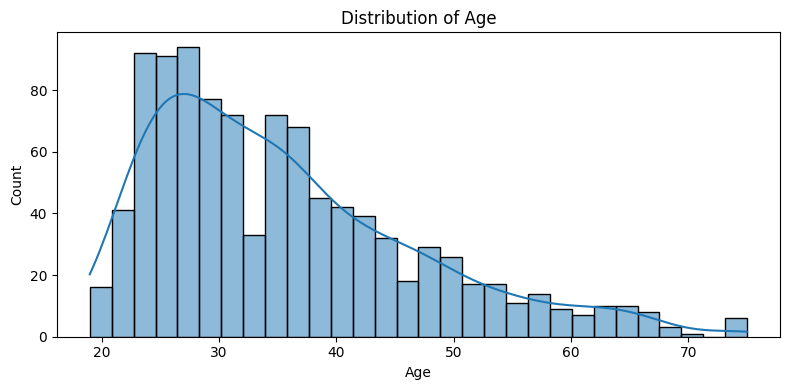

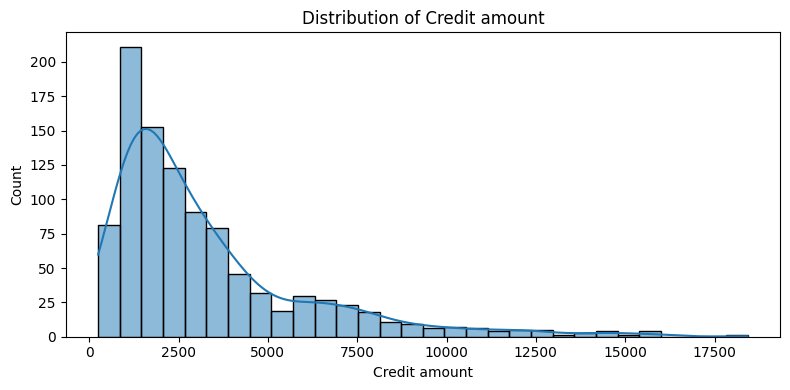

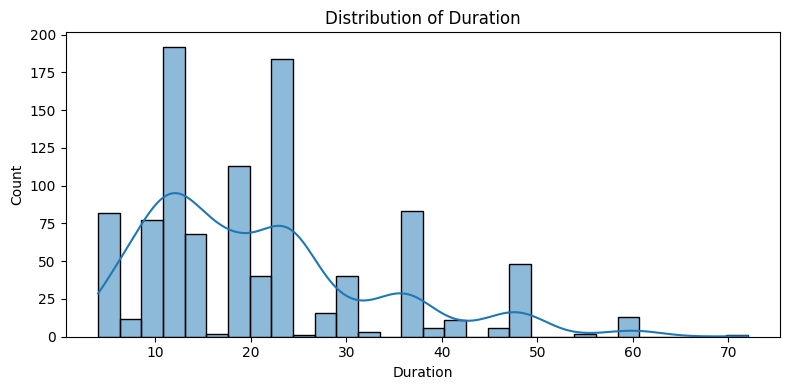

In [27]:
num_cols=['Age','Credit amount', 'Duration']
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sbn.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

Here’s what we can observe from the univariate analysis:

* Age: Most people are between 20–40 years old.
* Credit Amount: A few people have taken loans above 10,000, indicating potential outliers.
* Duration: Most loans are for short to medium durations, especially under 24 months.

Even though it's stored as a number, Job should be treated like a categorical variable during modeling because its values represent classes, not continuous quantities.

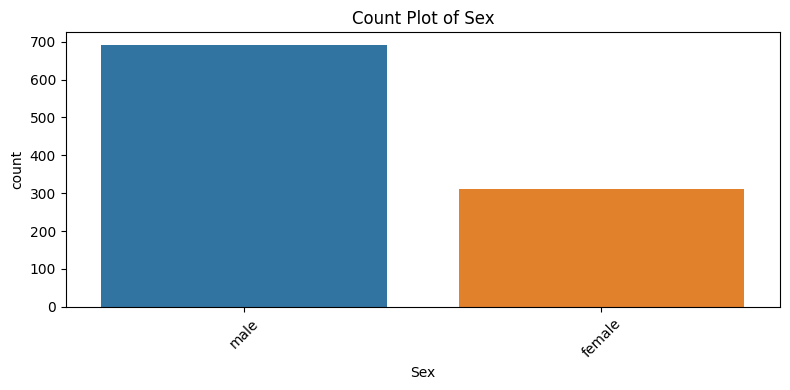

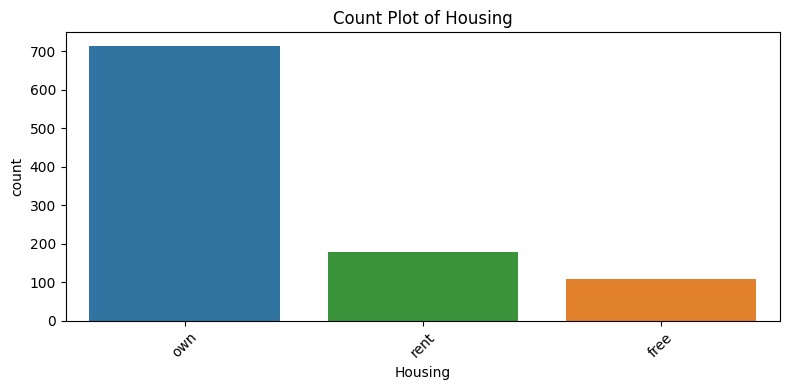

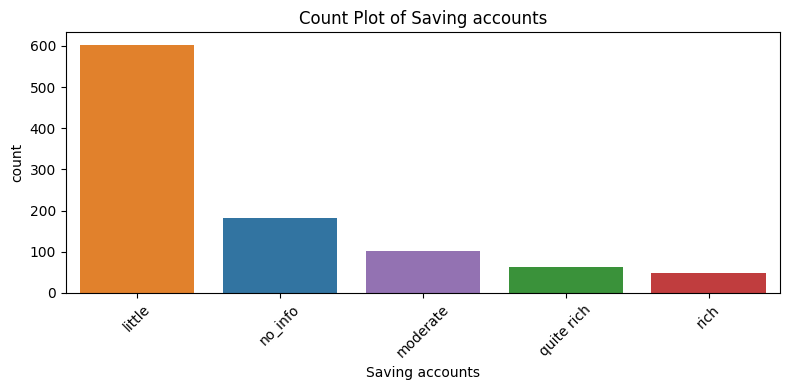

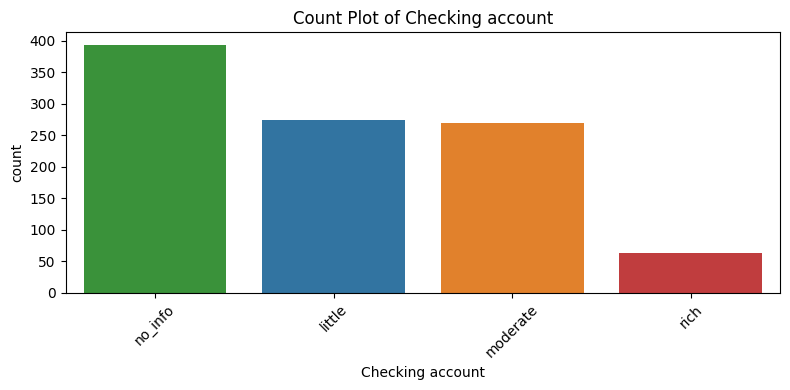

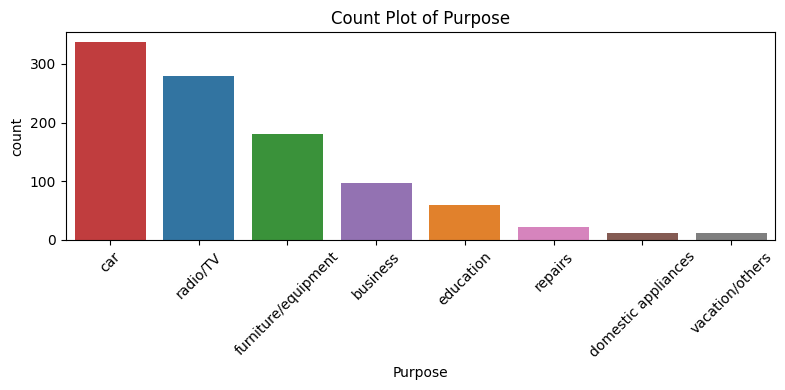

In [28]:
cat_cols = ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sbn.countplot(data=df, x=col, order=df[col].value_counts().index,hue=col)
    plt.title(f'Count Plot of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Data normalization

In [29]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
df[['Age', 'Credit amount', 'Duration']] = scaler.fit_transform(df[['Age', 'Credit amount', 'Duration']])


In [32]:
# Encode categorical features, we convert the labels into unique numbers
#e.g. ['male', 'female', 'male'] becomes [1,0,1]
df_encoded = df.copy()
label_encoders = {}
for column in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

print(df_encoded.head())

        Age  Sex  Job  Housing  Saving accounts  Checking account  \
0  0.857143    1    2        1                2                 0   
1  0.053571    0    2        1                0                 1   
2  0.535714    1    1        1                0                 2   
3  0.464286    1    2        0                0                 0   
4  0.607143    1    2        0                0                 0   

   Credit amount  Duration  Purpose  
0       0.050567  0.029412        5  
1       0.313690  0.647059        5  
2       0.101574  0.117647        3  
3       0.419941  0.558824        4  
4       0.254209  0.294118        1  


# kMeans

In [31]:
# Find the optimal number of clusters using Silhouette Score
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_encoded)
    silhouette_avg = silhouette_score(df_encoded, labels)
    silhouette_scores.append(silhouette_avg)
    print(f"Number of clusters: {k}, Silhouette score: {silhouette_avg:.3f}")

Number of clusters: 2, Silhouette score: 0.423
Number of clusters: 3, Silhouette score: 0.360
Number of clusters: 4, Silhouette score: 0.319
Number of clusters: 5, Silhouette score: 0.282
Number of clusters: 6, Silhouette score: 0.252
Number of clusters: 7, Silhouette score: 0.238
Number of clusters: 8, Silhouette score: 0.239
Number of clusters: 9, Silhouette score: 0.218
Number of clusters: 10, Silhouette score: 0.214


The best valuae for k is 2. So, two clusters well be determined. 

In [33]:

# Final KMeans with optimal k
kmeans_final = KMeans(n_clusters=2, random_state=42, n_init=10)
final_labels = kmeans_final.fit_predict(df_encoded)

# Add the cluster labels to the original DataFrame
df['cluster'] = final_labels

# Show clusters 
cluster_counts = df['cluster'].value_counts()
print("Number of clients in each cluster:")
print(cluster_counts)

Number of clients in each cluster:
cluster
0    554
1    446
Name: count, dtype: int64


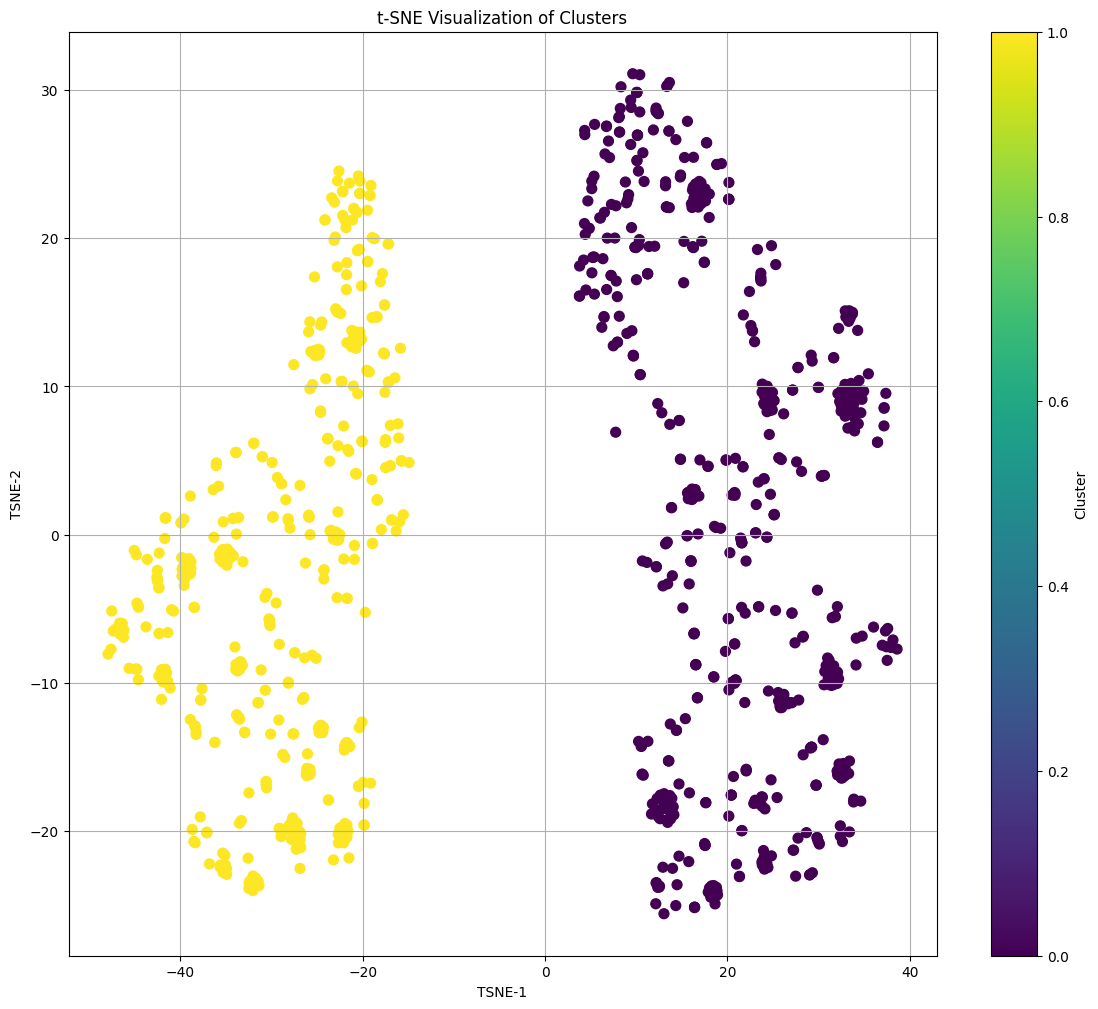

In [34]:
# Visualization with TSNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(df_encoded)
plt.figure(figsize=(14, 12))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=final_labels, cmap='viridis', s=50)
plt.title('t-SNE Visualization of Clusters')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

Cluster 0: Younger, smaller loans, short-term, consumer goods.

Cluster 1: Slightly older, larger loans, possibly for vehicles, and longer durations.

Both clusters are quite similar demographically, but differ in loan size and purpose.

# Evaluation 

In [36]:
silhouette_avg = silhouette_score(df_encoded, final_labels)
davies_bouldin = davies_bouldin_score(df_encoded, final_labels)
calinski = calinski_harabasz_score(df_encoded, final_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Calinski-Harabasz Index: {calinski:.4f}")

Silhouette Score: 0.4227
Davies-Bouldin Index: 0.9905
Calinski-Harabasz Index: 910.5878


* Silhouette score indicates that clusters are moderately distinct, not perfectly separated
* The DBI ranges from 0 to ∞, where lower values indicate better clustering. The value 0.9905 indicates moderate clustering.
* The value of Calinski-Harabasz score indicates on average separetion of the groups

In [37]:
df.to_csv('kmeans_2_clusters.csv')